Explore some period in the history of cinematography. For concreteness, I chose all movies that was released before 1950.

**goal 1**: According data in the dataset, plot changes from year to year:
* number of movies
* average rating of all movies in a year
* average popularity (total number of ratings for year / number of movies)

**goal 2**: Count number of movies of different genres.

**goal 3**: Select one genre (e.g. 'Documentary') and graph number of movies of this genre per year.

**goal 4**: Determine with what other genres the movies of the defined genre are adjacent.


The program should be created in flexible way, allowing easily change period and genre.

For project there were used data base MovieLens ml-25m from [grouplens.org](https://grouplens.org/datasets/movielens/).

In [1]:
import pandas as pd
%matplotlib inline

PATH_MOVIELENS = '/media/l3m/LinuxFilesBig/1-datasets/movielens (ml-25m)/'

<br>

#### Preliminary step 1: Load data bases

Load data base with movies:

In [2]:
movies = pd.read_csv(PATH_MOVIELENS+'movies.csv', index_col=0)
movies.head(3)

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance


<br>

Load data base with ratings:

In [3]:
ratings = pd.read_csv(PATH_MOVIELENS+'ratings.csv')
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828


<br>

Check than in data base 'ratings' all rating are correct - higher than 0 and not higher than 5:

In [4]:
assert (ratings['rating'] > 0).all(), "In the data base there's rating 0 or lower"

assert not (ratings['rating'] > 5).any(), "In the data base there's rating higher than 5"

<br>

Remove unnecessary column 'timestamp' for simplicity, performance and memory saving:

In [5]:
ratings.drop('timestamp', axis=1, inplace=True)
#alternative: del ratings['timestamp']

ratings.head(3)

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0


<br>
<br>

#### Preliminary step 2: Extend data bases

Extract year from title of movie and place it in separate column.<br>
Year is determined as string inside '()', the first character of which is '1' or '2', then 3 digits.

In [6]:
year_of_movies = movies['title'].str.extract('.*\(([12]\d{3})\).*')

movies.insert(1, 'year', year_of_movies)


movies.head(3)

,title,year,genres
movieId,,,
1,Toy Story (1995),1995,Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),1995,Adventure|Children|Fantasy
3,Grumpier Old Men (1995),1995,Comedy|Romance


In [7]:
# Alternative: extract year in separate column and change order of columns

# movies['year'] = movies['title'].str.extract('.*\(([12]\d{3})\).*')

# cols = movies.columns.tolist()
# cols = [cols[0]] + [cols[2]] + [cols[1]]
# movies = movies[cols]

# movies.head()

<br>

Create temporary DataFrame, containing averate rating of movies:

In [8]:
movies_stat = ratings[['movieId','rating']].groupby('movieId').agg([pd.DataFrame.mean, pd.Series.count])
movies_stat.columns = ['av_rating', 'nmb_ratings']

movies_stat.head(3)

,av_rating,nmb_ratings
movieId,,
1,3.893708,57309.0
2,3.251527,24228.0
3,3.142028,11804.0


<br>

Combine DataFrames:

In [9]:
movies = movies.join(movies_stat)
#alternative: movies = pd.concat([movies, movies_stat], axis=1)

movies.head(3)

,title,year,genres,av_rating,nmb_ratings
movieId,,,,,
1,Toy Story (1995),1995,Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309.0
2,Jumanji (1995),1995,Adventure|Children|Fantasy,3.251527,24228.0
3,Grumpier Old Men (1995),1995,Comedy|Romance,3.142028,11804.0


<br>

Delete temporary DataFrames 'ratings' and 'movies_stat' for memory saving.

In [10]:
if ('year_of_movies' in globals()):
    del year_of_movies

if ('ratings' in globals()):
    del ratings

if ('movies_stat' in globals()):
    del movies_stat

<br>

Some additional processing of DataFrame 'movies'.<br>
At first, look what we have:

In [11]:
print(movies.shape)
print()
print(movies.dtypes)

(62423, 5)

title           object
year            object
genres          object
av_rating      float64
nmb_ratings    float64
dtype: object


Remove rows where 'year' is <code>NaN</code>:

In [12]:
movies = movies.dropna(subset = ['year'])

At this moment data in column 'year' have type <code>string</code>. Change it to <code>int</code>:

In [13]:
movies['year'] = movies['year'].astype('int')
#alternative: movies.year = movies.year.map(lambda y: int(y))

Check that we accidentally extract in the column 'year' inappropriate date:

In [14]:
from datetime import date
current_year = date.today().year

#Alternative:
# from datetime import datetime
# current_year = datetime.now().year  # but datetime.now() returns more information,
                                      # so for such case it's worse

assert (movies['year'] >= 1874).all(), "There's year less than 1874. It's interesting."
assert (movies['year'] <= current_year).all(), "There's year greater than current"

Some cells in the column 'number_of_ratings' contain `NaN` values. Change them to `0`. Also transform type of data in this column from `float` to `int`.

In [15]:
movies['nmb_ratings'].fillna(0, inplace=True)
movies['nmb_ratings'] = movies['nmb_ratings'].astype('int')

Sort DataFrame by year:

In [16]:
movies.sort_values(by='year', inplace=True)

Check what we have now:

In [17]:
print(movies.shape)
print()
print(movies.dtypes)

movies.head(3)

(62013, 5)

title           object
year             int64
genres          object
av_rating      float64
nmb_ratings      int64
dtype: object


,title,year,genres,av_rating,nmb_ratings
movieId,,,,,
148054,Passage de Venus (1874),1874,Documentary,3.027778,18
148048,Sallie Gardner at a Gallop (1878),1878,(no genres listed),2.909091,22
202045,Athlete Swinging a Pick (1880),1880,Documentary,2.666667,3


<br>

Replace `(no genres listed)` in genres by `-`

In [18]:
movies['genres'].replace('(no genres listed)', 'n/a', inplace=True)

In [19]:
movies.head(10)

,title,year,genres,av_rating,nmb_ratings
movieId,,,,,
148054,Passage de Venus (1874),1874,Documentary,3.027778,18
148048,Sallie Gardner at a Gallop (1878),1878,n/a,2.909091,22
202045,Athlete Swinging a Pick (1880),1880,Documentary,2.666667,3
166800,Buffalo Running (1883),1883,n/a,2.636364,11
148040,Man Walking Around a Corner (1887),1887,n/a,1.750000,16
148042,Accordion Player (1888),1888,Documentary,1.928571,14
176849,Roundhay Garden Scene (1888),1888,Documentary,2.605263,19
148050,Traffic Crossing Leeds Bridge (1888),1888,Documentary,2.375000,20
180503,Pferd und Reiter Springen Über ein Hindernis (...,1888,Documentary,2.583333,6


<br>

Remove year from title.<br>
(*I use so complicated expression because in some titles the year was in the middle.<br>
E.g. movieId 141628: 'The Naked Truth (1957) (Your Past Is Showing)'*)

In [20]:
movies['title'] = movies['title'].str.extract('(.*)\([12]\d{3}\).*') + \
                  movies['title'].str.extract('.*\([12]\d{3}\) ?(.*)')

assert len(movies[movies['title'] == '']) == 0, "There's row with empty title"

print(movies.loc[141628,'title'])
movies.head()

The Naked Truth (Your Past Is Showing)


,title,year,genres,av_rating,nmb_ratings
movieId,,,,,
148054,Passage de Venus,1874,Documentary,3.027778,18
148048,Sallie Gardner at a Gallop,1878,n/a,2.909091,22
202045,Athlete Swinging a Pick,1880,Documentary,2.666667,3
166800,Buffalo Running,1883,n/a,2.636364,11
148040,Man Walking Around a Corner,1887,n/a,1.750000,16


<br>
<br>

#### Goal 1: Plot different characteristics of movies per year

In [21]:
year_begin = 0
year_end = 1950

Find earliest and latest movies in the DataFrame. Use this information to correct variables `year_begin` and `year_end` to eliminate blank ends.

In [22]:
earliest_movie = movies['year'].min()
latest_movie = movies['year'].max()

year_begin = max(year_begin, earliest_movie)
year_end = min(year_end, latest_movie)

year_begin, year_end

(1874, 1950)

<br>

Create subset of 'movies' DataFrame to work with it more conveniently:

In [23]:
mvs = movies[(movies['year'] >= year_begin) & (movies['year'] <= year_end)]

mvs.head()

,title,year,genres,av_rating,nmb_ratings
movieId,,,,,
148054,Passage de Venus,1874,Documentary,3.027778,18
148048,Sallie Gardner at a Gallop,1878,n/a,2.909091,22
202045,Athlete Swinging a Pick,1880,Documentary,2.666667,3
166800,Buffalo Running,1883,n/a,2.636364,11
148040,Man Walking Around a Corner,1887,n/a,1.750000,16


<br>

Some simple statistics about this period just for general familiarization:

In [24]:
print('Number of movies                   :', len(mvs))
print('Average rating of all movies       :', round(mvs['av_rating'].mean(), 1))
print('Std deviation of average ratings   :', round(mvs['av_rating'].std(), 2))
print('Average number of ratings per movie:', round(mvs['nmb_ratings'].mean(), 1))

Number of movies                   : 5761
Average rating of all movies       : 3.1
Std deviation of average ratings   : 0.62
Average number of ratings per movie: 101.2


<br>

Create DataFrame, containing general statistics about movies per year:
* Number of movies released this year
* Average rating of movies in this year
* Average popularity

In [25]:
def handle_year(gr):
    nmb_movies = len(gr)
    av_rating_per_year = gr['av_rating'].mean()
    av_popularity = gr['nmb_ratings'].mean()
    
    return pd.Series({'nmb_movies': nmb_movies,
                      'av_rating_per_year': round(av_rating_per_year, 1),
                      'av_nmb_ratings': round(av_popularity, 1)
                     })

movies_per_year = mvs.groupby('year').apply(handle_year)

movies_per_year.head()

,nmb_movies,av_rating_per_year,av_nmb_ratings
year,,,
1874,1.0,3.0,18.0
1878,1.0,2.9,22.0
1880,1.0,2.7,3.0
1883,1.0,2.6,11.0
1887,1.0,1.8,16.0


<br>

Fill in spaces and make the DataFrame more neat:
* Fill in years without released movies with NaN values
* Replace NaN by 0
* Transform in some columns type of data from float to int

In [26]:
movies_per_year = pd.DataFrame(movies_per_year, index=range(year_begin, year_end+1))

movies_per_year.fillna(0, inplace=True)

movies_per_year['nmb_movies'] = movies_per_year['nmb_movies'].astype('int')

movies_per_year.head()

,nmb_movies,av_rating_per_year,av_nmb_ratings
1874,1,3.0,18.0
1875,0,0.0,0.0
1876,0,0.0,0.0
1877,0,0.0,0.0
1878,1,2.9,22.0


<br>

Number of movies per year:

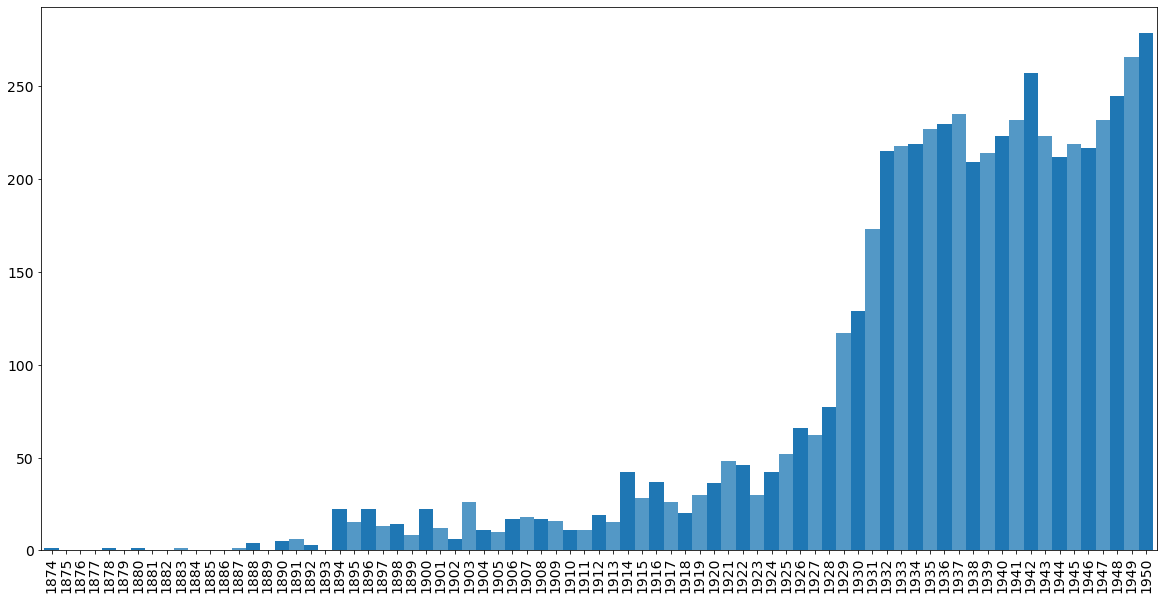

In [27]:
movies_per_year['nmb_movies'].plot(kind='bar', width=1, figsize=(20,10),
                                   color=['#1F77B4', '#5398C6'], fontsize = 14)

<br>

Average rating of all movies:

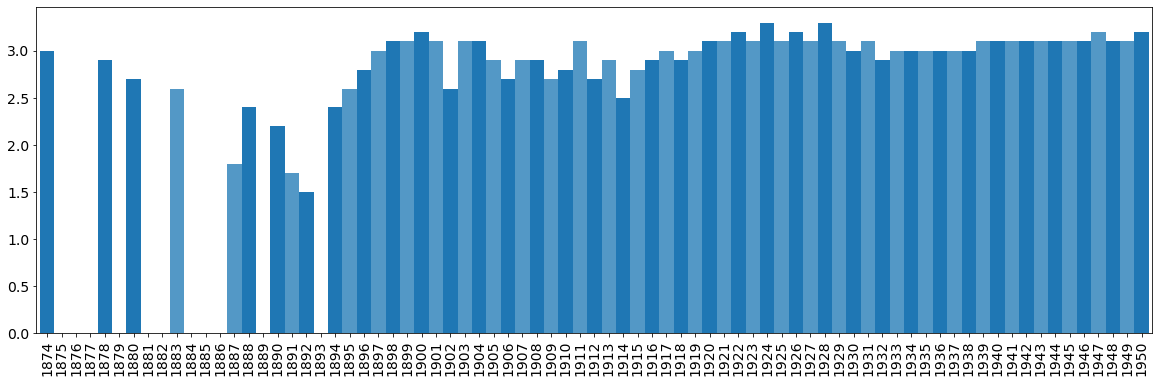

In [28]:
movies_per_year['av_rating_per_year'].plot(kind='bar', width=1, figsize=(20,6),
                                           color=['#1F77B4', '#5398C6'], fontsize = 14)

<br>

Average number of ratings per movie during a year<br>
(*that determines average popularity among viewers movies of this year*):

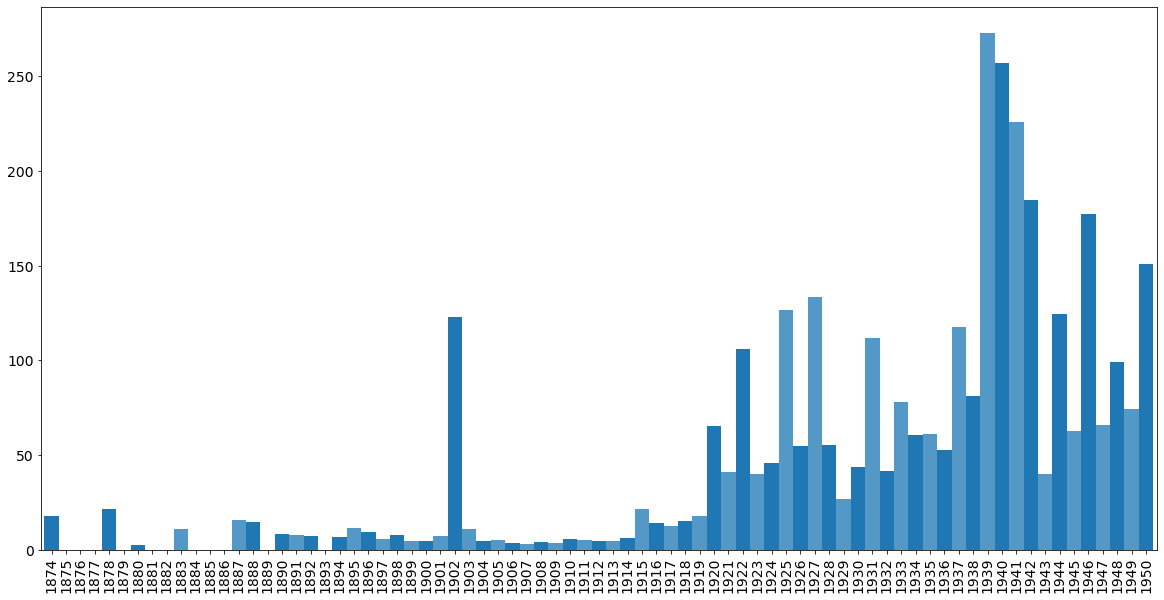

In [29]:
movies_per_year['av_nmb_ratings'].plot(kind='bar', width=1, figsize=(20,10),
                                       color=['#1F77B4', '#5398C6'], fontsize = 14)

#### <br>
<br>

#### Goal 2: Genres of movies during the period

In [30]:
mvs_by_genres = pd.concat([mvs['title'],
                           mvs['year'],
                           mvs['genres'].str.split('|', expand=True)
                          ], axis=1)

mvs_by_genres.head()

,title,year,0,1,2,3,4,5,6
movieId,,,,,,,,,
148054,Passage de Venus,1874,Documentary,None,None,None,None,None,None
148048,Sallie Gardner at a Gallop,1878,n/a,None,None,None,None,None,None
202045,Athlete Swinging a Pick,1880,Documentary,None,None,None,None,None,None
166800,Buffalo Running,1883,n/a,None,None,None,None,None,None
148040,Man Walking Around a Corner,1887,n/a,None,None,None,None,None,None


<br>

Number of movies of different genres.<br>
(*At first, I separately count number of movies in each column, them summarize results in each row, then transfort type of data from float to integer. I'm sure that there's more easy way, but I don't know it.*)

In [31]:
number_genres = mvs_by_genres.iloc[:, 2:].apply(pd.value_counts).sum(axis=1) \
                                         .astype('int').sort_values(ascending=False)
number_genres

Drama          2422
Comedy         1741
Romance        1292
Crime           614
n/a             582
Animation       448
Mystery         429
Adventure       359
Thriller        356
War             313
Western         310
Action          288
Musical         272
Fantasy         228
Horror          212
Film-Noir       203
Children        166
Documentary     149
Sci-Fi           91
dtype: int64

<br>

Number of movies per genres:

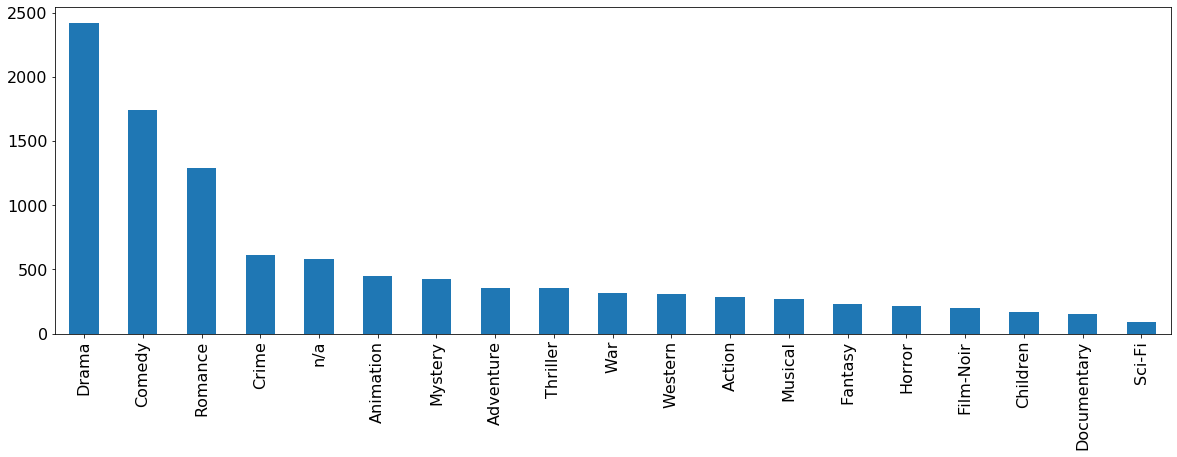

In [32]:
number_genres.plot(kind='bar', figsize=(20, 6), fontsize = 16)

<br>
<br>

#### Goal 3: Movies of definite genre per year

In [33]:
gnr = 'Documentary'

Select movies that contain defined genre in the column 'genres'

In [34]:
mvs_of_genre = mvs[mvs['genres'].str.contains(gnr)]

mvs_of_genre.head()

,title,year,genres,av_rating,nmb_ratings
movieId,,,,,
148054,Passage de Venus,1874,Documentary,3.027778,18
202045,Athlete Swinging a Pick,1880,Documentary,2.666667,3
148042,Accordion Player,1888,Documentary,1.928571,14
176849,Roundhay Garden Scene,1888,Documentary,2.605263,19
148050,Traffic Crossing Leeds Bridge,1888,Documentary,2.375000,20


<br>

Count number of movies with defined genre per year:

In [35]:
number_mvs_of_genre = mvs_of_genre.groupby('year').size()

number_mvs_of_genre.head()

year
1874     1
1880     1
1888     4
1891     4
1894    14
dtype: int64

<br>

Years of the oldest and latest movies of defined genre:

In [36]:
year_genre_oldest = number_mvs_of_genre.index.min()
year_genre_latest = number_mvs_of_genre.index.max()

year_genre_oldest, year_genre_latest

(1874, 1950)

<br>

Handle details of the Series:
* Fill in years without data with NaN values
* Replace NaN by 0
* Transform type from float to int

In [37]:
number_mvs_of_genre = pd.Series(number_mvs_of_genre, index=range(year_genre_oldest, year_genre_latest+1))
number_mvs_of_genre.fillna(0, inplace=True)
number_mvs_of_genre = number_mvs_of_genre.astype('int')

number_mvs_of_genre.head()

1874    1
1875    0
1876    0
1877    0
1878    0
dtype: int64

Total number of movies of defined genre in defined perios:

In [38]:
number_mvs_of_genre.sum()

149

<br>

Number of movies of defined genre per year:

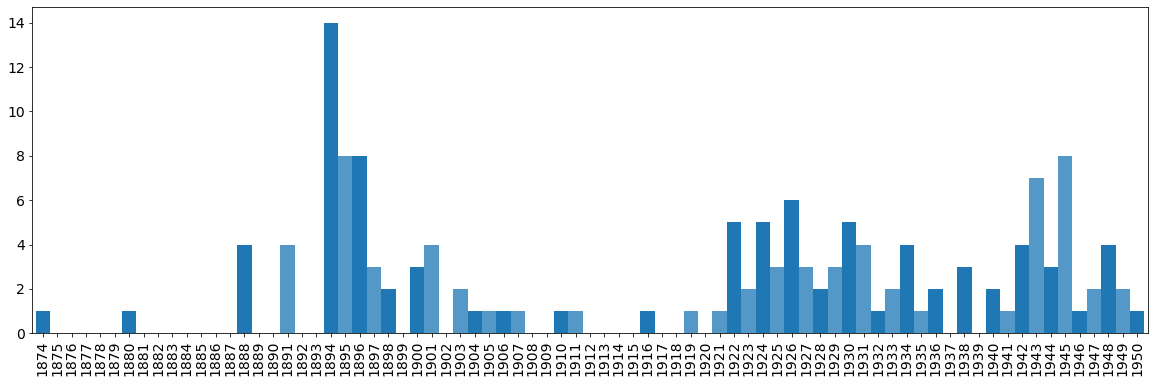

In [39]:
number_mvs_of_genre.plot(kind='bar', width=1, figsize=(20,6),
                         color=['#1F77B4', '#5398C6'], fontsize = 14)

<br>
<br>

#### Goal 3-extended: Comparison of movies of several genres

In [40]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 8)  # plt.rc('figure', figsize=(20, 6))
plt.rcParams['font.size'] = 14            # plt.rc('font', size=14)

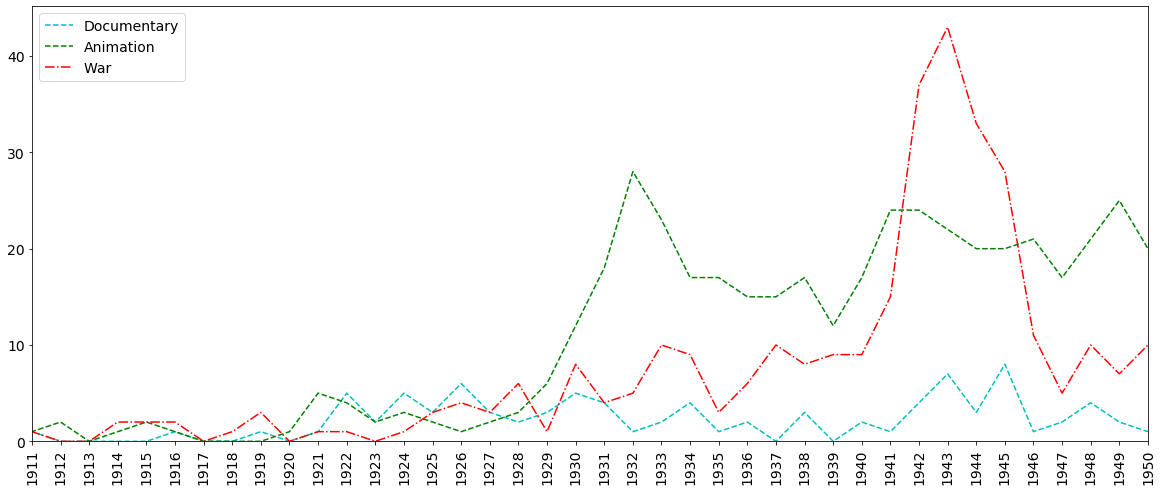

In [41]:
gnrs = ['Documentary', 'Animation', 'War']

year_graph_oldest = 1911 #year_begin
year_graph_latest = year_end

styles = ['c--', 'g--', 'r-.', 'm:', 'b--', 'y', 'b:']

for i, gnr in enumerate(gnrs):
    mvs_with_gnr = mvs_by_genres[(mvs_by_genres.iloc[:, 2:] == gnr).any(axis=1)]
    number_mvs_of_genre = mvs_with_gnr.groupby('year').size()
    
    year_genre_oldest = mvs_with_gnr['year'].min()
    year_genre_latest = mvs_with_gnr['year'].max()
    
    number_mvs_of_genre = pd.Series(number_mvs_of_genre,
                                    index=range(year_genre_oldest, year_genre_latest+1))
    number_mvs_of_genre.fillna(0, inplace=True)
    number_mvs_of_genre = number_mvs_of_genre.astype('int')

    plt.plot(number_mvs_of_genre.index, number_mvs_of_genre, styles[i], label=gnr)

plt.xlim(year_graph_oldest, year_graph_latest)
plt.ylim(0)

labels = range(year_graph_oldest, year_graph_latest+1)
plt.xticks(labels, rotation='vertical')

plt.legend(loc='upper left')

<br>
<br>

#### Goal 4: Combination of defined genre with other genres

Select movies with defined genre. For that we use already created  DataFrame 'mvs_with_gnr'.<br>
(*Using 'mvs_of_genre' would be simpler way, but boring in terms of programming.*)

In [42]:
mvs_with_gnr = mvs_by_genres[(mvs_by_genres.iloc[:, 2:] == gnr).any(axis=1)]

assert len(mvs_with_gnr) == number_mvs_of_genre.sum(), 'something wrong with number of movies'

mvs_with_gnr.head()

,title,year,0,1,2,3,4,5,6
movieId,,,,,,,,,
173997,The Surrender of Tournavos,1897,Action,Drama,War,None,None,None,None
174329,In the Border States,1910,Drama,War,None,None,None,None,None
157002,The Battle,1911,Drama,War,None,None,None,None,None
92883,"Mysterious X, The (Sealed Orders) (Det hemmeli...",1914,Drama,War,None,None,None,None,None
74097,Cabiria,1914,Adventure,Drama,War,None,None,None,None


<br>

Count number of adjacent genres. Delete from resulted Series initial genre.

In [43]:
number_adjacent_genres = mvs_with_gnr.iloc[:, 2:].apply(pd.value_counts).sum(axis=1) \
                                                 .astype('int').sort_values(ascending=False)

number_adjacent_genres.drop(gnr, inplace=True)
#alternative: del number_adjacent_genres[gnr]

number_adjacent_genres

Drama          227
Romance         82
Action          40
Comedy          38
Adventure       34
Thriller        16
Documentary     14
Western          7
Musical          6
Mystery          5
Animation        5
Film-Noir        3
Horror           3
Sci-Fi           3
Crime            2
Fantasy          2
Children         1
dtype: int64

<br>

Number of adjacent genres:

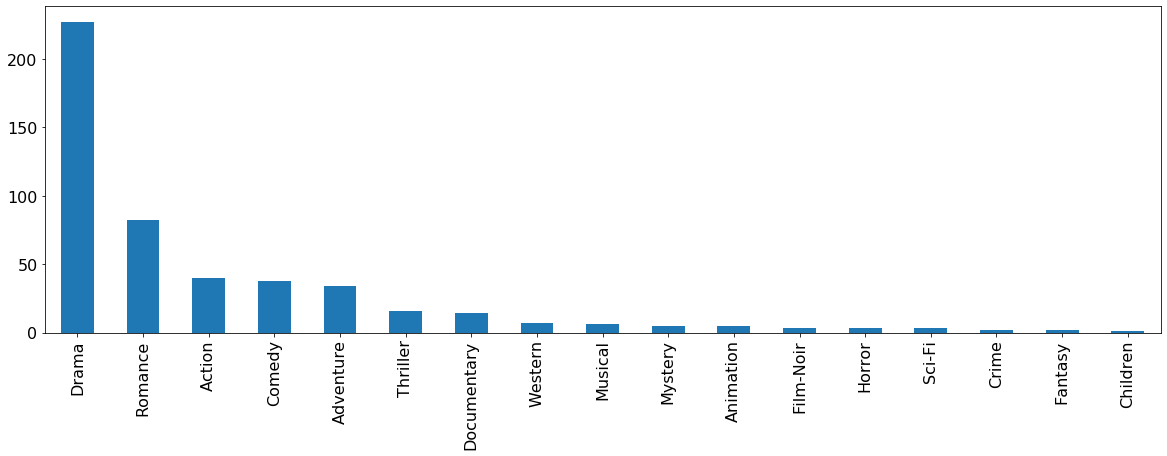

In [44]:
number_adjacent_genres.plot(kind='bar', figsize=(20,6), fontsize = 16)

Number of movies without adjacent genres:<br>
(*I use trick that in such case the second column of genre contains 'None'*)

In [45]:
len(mvs_with_gnr[mvs_with_gnr[1].isnull()])

10